In [1]:
import scipy.special as sp
import math as ma
import numpy as np
import scipy.stats as st
import numba as nb
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize

# Exponential distribution

$X\sim\text{Exp}(\lambda)$ with pdfs

$$
f(x) = \lambda e^{-\lambda x}
$$

In [1]:
class loss_model:
    def __init__(self,name, parm_names):
        self.name = name
        self.parm_names = parm_names
        self.d= len(parm_names)
    
    def set_logps(self):
        if self.name == "Exp":
            def logp(X, parms):
                λ = parms[0]
                if λ > 0:
                    return(len(X) * np.log(λ) - λ * np.sum(X))
                else:
                    return(-np.inf)

            def logp_body(X, parms,  γ):
                λ = parms[0]
                if λ > 0:
                    return(len(X) * np.log(λ) - λ * np.sum(X) - len(X) * np.log(1-np.exp(- λ * γ)))
                else:
                    return(-np.inf)
            
            def logp_tail(X, parms,  γ):
                λ = parms[0]
                if λ > 0:
                    return(len(X) * np.log(λ) - λ * (np.sum(X) - len(X) * γ))
                else:
                    return(-np.inf)
            self.logp = nb.jit(nopython = True)(logp)
            self.logp_body = nb.jit(nopython = True)(logp_body)
            self.logp_tail = nb.jit(nopython = True)(logp_tail)
    
    def set_logds(self):
        if self.name == "Exp":
            def logd(x, parms):
                λ = parms[:,0]
                res = np.zeros(len(λ))
                s = λ > 0
                res[np.where(s)] = np.log(λ[s]) - λ[s] * x
                res[np.where(np.invert(s))] = -np.inf
                return(res)

            def logd_body(x, parms,  γ):
                λ = parms[:,0]
                res = np.zeros(len(λ))
                s = np.logical_and(λ > 0, x < γ)
                res[np.where(s)] = np.log(λ[s])- λ[s] * x - np.log(1-np.exp(- λ[s] * γ[s]))
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            
            def logd_tail(x, parms,  γ):
                λ = parms[:,0]
                res = np.zeros(len(λ))
                s = np.logical_and(λ > 0, x > γ)
                res[np.where(s)] = np.log(λ[s]) - λ[s] * (x - x * γ[s])
                res[np.where(np.invert(s))] = -np.inf
                return(res)
            self.logd = nb.jit(nopython = True)(logd)
            self.logd_body = nb.jit(nopython = True)(logd_body)
            self.logd_tail = nb.jit(nopython = True)(logd_tail)
                
    def cdf(self, parms, x):
        if self.name == "Exp":
            λ = parms[0]
            return(1 - np.exp(- λ * x))
    def ppf(self, parms, y):
        if self.name == "Exp":
            λ = parms[0]
            return( -np.log(1-y) / λ )

## Basic checks

In [4]:
exp_dist = single_loss_model("Exp", ["λ"])
print(exp_dist.name, exp_dist.parm_names, exp_dist.d)
λ, x, y = np.array([1/3]), 2, 0.5
exp_dist.cdf(λ, x) - st.expon().cdf(x * λ[0]), exp_dist.ppf(λ, y) - st.expon().ppf(y) / λ[0]

Exp ['λ'] 1


(0.0, 0.0)

## Log likelihood checks
### Part 1

In [5]:
X, γ = np.random.exponential(λ[0], size = 10), 2
exp_dist.set_logps()
print(exp_dist.logp(X, λ) - np.sum(np.log(st.expon().pdf(X * λ[0]) * λ[0])))
print(exp_dist.logp_body(X, λ, γ) -  np.sum(np.log(st.expon().pdf(X * λ[0]) * λ[0] / st.expon().cdf(γ * λ[0]))))
print(exp_dist.logp_tail(X, λ, γ)-  np.sum(np.log(st.expon().pdf(X * λ[0]) * λ[0] / (1 - st.expon().cdf(γ * λ[0])))))

-1.7763568394002505e-15
-1.7763568394002505e-15
-2.6645352591003757e-15


### Part 2

In [6]:
X = np.random.exponential(λ[0], size = 10)
particle_cloud = pd.DataFrame({'λ': np.array([1, 2, 1/8, -1]),
                               'γ': np.array([1, 2,4,8])})
exp_dist.set_logds()
exp_dist.logd(X[0], particle_cloud.values), exp_dist.logd_body(X[0], particle_cloud.values, particle_cloud.values[:,-1]), exp_dist.logd_tail(X[0], particle_cloud.values, particle_cloud.values[:,-1]) 

(array([-0.2120565 ,  0.26903418, -2.1059486 ,        -inf]),
 array([ 0.24661864,  0.28751963, -1.17319647,        -inf]),
 array([-inf, -inf, -inf, -inf]))

## In the composite model

In [72]:
class composite_loss_model():
    def __init__(self, f1, f2):
        self.body = f1
        self.tail = f2
        self.d = f1.d + f2.d + 2 
        self.parm_names = np.append(np.append(f1.parm_names, f2.parm_names), np.array(['γ','p']))

    
    def set_logp(self, X):
        self.body.set_logps(), self.tail.set_logps()
        def logp(parms):
            parms_f1, parms_f2, γ, p = parms[:self.body.d], parms[self.body.d: (self.body.d + self.tail.d)], parms[(self.body.d + self.tail.d)], parms[-1]
            if γ > 0 and p > 0 and p < 1:
                X1 = X[X < γ]
                X2 = X[X >= γ]
                return(len(X1) * np.log(p) + self.body.logp_body(X1, parms_f1, γ) + len(X2) * np.log(1-p) + self.tail.logp_tail(X2, parms_f2, γ))
            else:
                return(-np.inf)
        self.logp = logp
        
    def sample(self, parms, n):
        parms_f1, parms_f2, γ, p = parms[:self.body.d], parms[self.body.d: (self.body.d + self.tail.d)], parms[(self.body.d + self.tail.d)], parms[-1]
        ber_rvs = np.random.binomial(1, p, size=n)
        unif_rvs = np.random.uniform(size = n)
        body_rvs = self.body.ppf(parms_f1, self.body.cdf(parms_f1, γ) * unif_rvs )
        tail_rvs = self.tail.ppf(parms_f2, 1 - (1 - self.tail.cdf(parms_f2, γ)) * unif_rvs)
        return(ber_rvs * body_rvs + (1 - ber_rvs) * tail_rvs)
    
    def set_logd(self, parms):
        self.body.set_logds(), self.tail.set_logds()
        parms_f1, parms_f2, γ, p = parms[:,:self.body.d], parms[:,self.body.d: (self.body.d + self.tail.d)], parms[:,(self.body.d + self.tail.d)], parms[:,-1]
        def logd(x):
            res = np.zeros(len(γ))
            s = np.logical_and(p > 0, p < 1)
            s1 = np.logical_and(s, x < γ)
            s2 = np.logical_and(s, x >= γ)
            res1 = self.body.logd_body(x, parms_f1[s1], γ[s1])    
            res2 = self.tail.logd_tail(x, parms_f2[s2], γ[s2])
            res[np.where(s1)] = res1
            res[np.where(s2)] = res2
            res[np.where(np.invert(s))] = - np.inf
            return(res)
        self.logd = logd
    

['λ1' 'λ2' 'γ' 'p']


<ipython-input-70-c09644ad6aa6>:11: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "logp" failed type inference due to: Untyped global name 'self': cannot determine Numba type of <class '__main__.composite_loss_model'>

File "<ipython-input-70-c09644ad6aa6>", line 12:
        def logp(parms):
            parms_f1, parms_f2, γ, p = parms[:self.body.d], parms[self.body.d: (self.body.d + self.tail.d)], parms[(self.body.d + self.tail.d)], parms[-1]
            ^

  def logp(parms):
C:\Users\pierr\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:177: NumbaWarning: Function "logp" was compiled in object mode without forceobj=True.

File "<ipython-input-70-c09644ad6aa6>", line 11:
        self.body.set_logps(), self.tail.set_logps()
        def logp(parms):
        ^

  warnings.warn(errors.NumbaWarning(warn_msg,
C:\Users\pierr\anaconda3\lib\site-packages\numba\core\object_mode_passes.py:187: NumbaDeprecationWarning: 
Fall-back 

-11964.293298361701


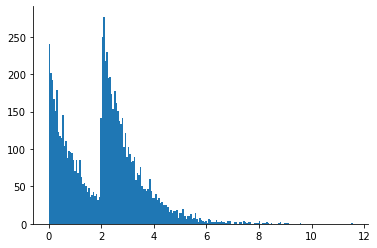

In [71]:
f1, f2 = single_loss_model("Exp", ["λ1"]), single_loss_model("Exp", ["λ2"])
f = composite_loss_model(f1 , f2)
print(f.parm_names)
parms_true = np.array([1, 1, 2, 0.4])
X = f.sample(parms_true, 8000)
plt.hist(X,bins=200)
sns.despine()
f.set_logp(X)
print(f.logp(parms_true))

In [60]:
def mle_composite(X, θ0, logp):
    n = len(X) 
    costFn = lambda parms: -logp(parms)
    bnds = ((0, None), (0, None), (0, None), (0,1))
    minRes = minimize(costFn, θ0, bounds=bnds)
    BIC = len(θ0) * np.log(n) - 2 * logp(minRes.x)
    AIC = 2 * len(θ0) - 2 * logp(minRes.x)
    return(minRes.x, BIC, AIC)
f.set_logp(X)
θ0, logp =np.array([0.5, 2, 3, 1/2]), f.logp
print(parms_true)
mle_composite(X, θ0, logp)

[1.  1.  2.  0.4]


C:\Users\pierr\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


(array([0.49999974, 1.99999895, 3.00137597, 0.50000026]),
 30660.071465341778,
 30632.12267805913)

In [64]:
# @nb.jit(nopython=False)
def Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, γ, d):   
    trace = [init_parms]
    accepted_matrix = [np.repeat(False,d)]
    for j in range(n_moves):
        parms_perturbed = trace[-1].copy()
        parms_new = trace[-1].copy()
        accepted = []
        for i in range(d):
            noise = np.random.normal(0, np.sqrt(step_size[i]))
            parms_perturbed[i] = parms_perturbed[i] + noise
            
            parms_new[i] = parms_perturbed[i]
            # acceptance rate
            old_log_p = γ * log_prob(trace[-1]) + log_prob_prior(trace[-1])
            new_log_p = γ * log_prob(parms_new) + log_prob_prior(parms_new)        
            ###
            acc =  new_log_p - old_log_p 
            ###       
            if np.log(np.random.rand()) < acc:
                parms_new[i] = parms_perturbed[i]
                accepted.append(True)
            else:
                parms_new[i] = trace[-1][i]
                # np.put(parms_new, i, trace[-1][i])
                accepted.append(False)
        trace.append(parms_new) 
        accepted_matrix.append(np.array(accepted))
                
     
    return(trace, accepted_matrix)

In [65]:
def sim_gamma_beta_prior(a, b, parms_names, popSize):
    mat = [st.gamma(a[j]).rvs(popSize) / b[j] 
               for j in range(len(a)-1)]
    mat.append(st.beta(a[-1], b[-1]).rvs(popSize))
    res = pd.DataFrame(np.matrix(mat).transpose())
    res.columns = parms_names
    return res
def logp_gamma_beta_prior(a, b):
    def logp_prior(parms):
        gammas, beta, a_gammas, a_beta, b_gammas, b_beta = parms[:len(parms)-1], parms[-1], a[:len(parms)-1], a[-1], b[:len(parms)-1], b[-1]
        if np.all(parms)>0 and beta < 1:
            l_gamma =  np.sum((a_gammas - 1) * np.log(gammas)) - np.sum(gammas * b_gammas) + np.sum(a_gammas * np.log(b_gammas)) - np.sum(np.log(np.array([ma.gamma( a_scalar ) for a_scalar in a_gammas])))
            l_beta = (a_beta - 1)*np.log(beta) + (b_beta - 1)*np.log(1 - beta) +  np.log(ma.gamma(a_beta)) + np.log(ma.gamma(b_beta)) - np.log(ma.gamma(a_beta + b_beta))

            return(l_gamma + l_beta)
        else:
            return(-np.inf)
    return nb.jit(nopython=True)(logp_prior)

In [66]:
a, b, popSize = np.append(0.1*np.ones(f.d-1), 2), np.append(0.1*np.ones(f.d-1), 2.0), 1
log_prob_prior, particles = logp_gamma_beta_prior(a, b), sim_gamma_beta_prior(a, b, f.parm_names, popSize) 
print(particles.values[0])
f.logp(particles.values[0])
n_moves, step_size, log_prob, log_prob_prior, init_parms, τ, d = 15000, np.array([1.14196723e-03, 2.41954715e-04, 1.96944245e-07, 3.63115063e-05]), f.logp, logp_gamma_beta_prior(a, b), particles.values[0], 1, f.d
trace, acceptance = Gibbs_move(n_moves, step_size, log_prob, log_prob_prior, init_parms, τ, d)
trace_gibbs = pd.DataFrame(trace).iloc[int(n_moves / 2):]
trace_gibbs.columns = f.parm_names

[1.18691531e-09 5.16578356e-10 1.60956698e-02 5.82390573e-01]


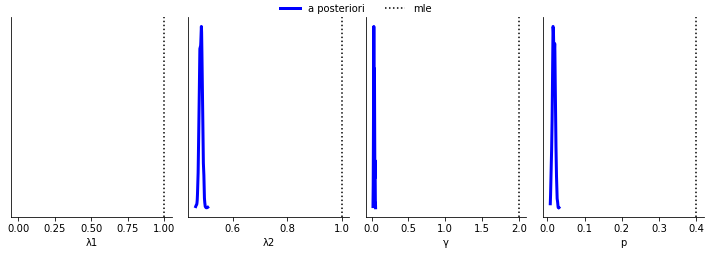

In [67]:
fig, axs = plt.subplots(1, f.d, figsize=(10, 3.5))
x_labs = f.parm_names
for k in range(len(x_labs)):
    positions = np.linspace(min(trace_gibbs[f.parm_names[k]]), max(trace_gibbs[f.parm_names[k]]), 1000)
    kernel = st.gaussian_kde(trace_gibbs[f.parm_names[k]])
    axs[k].plot(positions, kernel(positions), lw=3, label = "a posteriori", color = "blue")

    axs[k].axvline(parms_true[k], color = "black", linestyle = "dotted", label = "mle")
    axs[k].set_yticks([])
#     axs[k].set_xticks(np.round(
#         trace_gibbs[parms_names[k]].quantile([0.05, 0.95]).values, 2))
    axs[k].set_xlabel(x_labs[k])

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, ncol = 3, borderaxespad=0., loc='upper center', 
           frameon=False)
sns.despine()
fig.tight_layout()

In [20]:
np.diag(trace_gibbs.cov())

array([1.14196723e-03, 2.41954715e-04, 1.96944245e-07, 3.63115063e-05])